In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib


In [11]:
df=pd.read_csv("Data Files/iv_data.csv")

df = df.dropna(subset=["atm_iv"])



df["datetime"] = pd.to_datetime(df["date"].astype(str) + df["time"].astype(str),
                                format="%Y%m%d%H%M%S")


df = df.sort_values("datetime")
df = df.set_index("datetime")

print("Rows:", len(df))
print("First 5 rows:\n", df.head())
print("Last 5 rows:\n", df.tail())


Rows: 8225
First 5 rows:
                          date   time   cp_fut      index        str_px  \
datetime                                                                 
2025-01-23 09:16:00  20250123  91600  2311490  2309960.0   9113.414451   
2025-01-23 09:17:00  20250123  91700  2310750  2310185.0   9015.955478   
2025-01-23 09:18:00  20250123  91800  2311031  2310035.0   8584.762143   
2025-01-23 09:19:00  20250123  91900  2311759  2310370.0   9980.526316   
2025-01-23 09:20:00  20250123  92000  2311936  2310975.0  10040.318615   

                        exstr_px  dte  atm_strike_discrete  atm_iv  \
datetime                                                             
2025-01-23 09:16:00  7021.280139  0.0            2310000.0  0.1817   
2025-01-23 09:17:00  7740.430271  0.0            2310000.0  0.1814   
2025-01-23 09:18:00  6947.303451  0.0            2310000.0  0.1720   
2025-01-23 09:19:00  7699.922551  0.0            2310000.0  0.2001   
2025-01-23 09:20:00  7667.205897  0

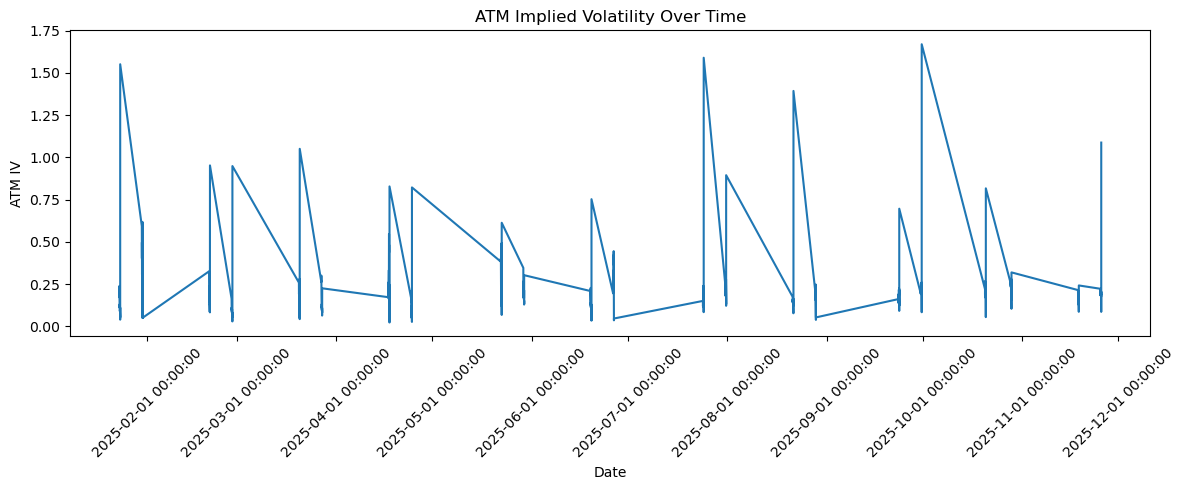

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["atm_iv"])
plt.title("ATM Implied Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("ATM IV")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))


plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()


In [13]:
df["iv_change"] = df["atm_iv"].diff() # difference b/w the consecutive rows in the atm_iv
df["iv_vol"] = df["atm_iv"].rolling(10).std() # standard deviation of last 10 atm_iv values





## Method1:Threshold-baesd Regimes


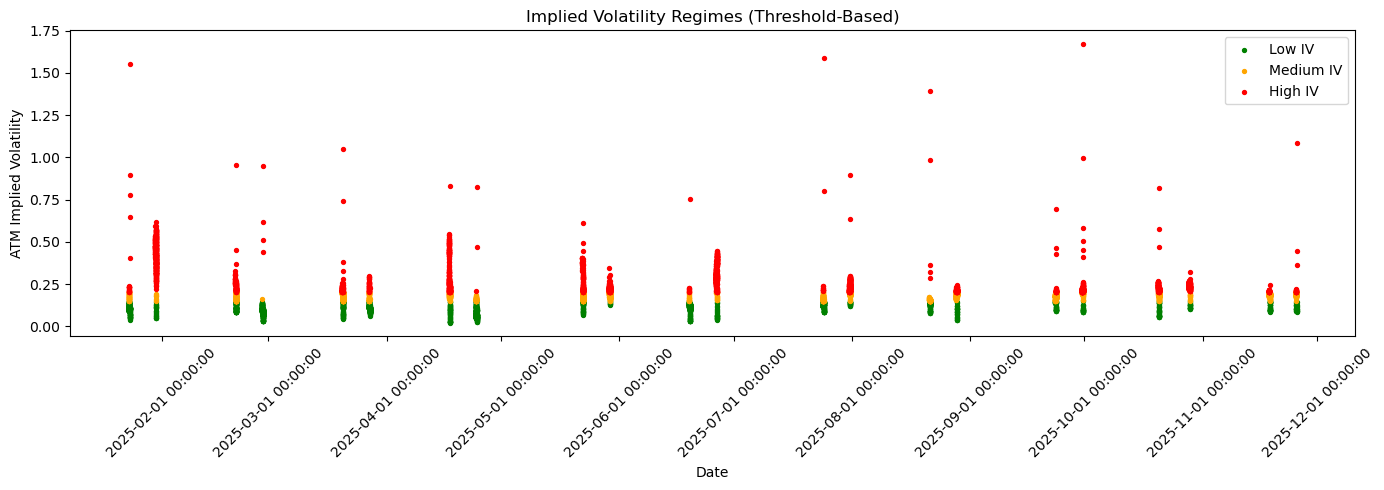

In [14]:

low = df["atm_iv"].quantile(0.33)
high = df["atm_iv"].quantile(0.66)

def label_regime(iv):
    if iv < low:
        return "Low IV"
    elif iv < high:
        return "Medium IV"
    else:
        return "High IV"

df["regime_threshold"] = df["atm_iv"].apply(label_regime)

# Plot Graph

plt.figure(figsize=(14,5))

colors = {
    "Low IV": "green",
    "Medium IV": "orange",
    "High IV": "red"
}

for regime, color in colors.items():
    subset = df[df["regime_threshold"] == regime]
    plt.scatter(subset.index, subset["atm_iv"],
                label=regime, color=color, s=8)

plt.title("Implied Volatility Regimes (Threshold-Based)")
plt.xlabel("Date")
plt.ylabel("ATM Implied Volatility")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.xticks(rotation=45) 
plt.tight_layout()
plt.legend()
plt.show()



## METHOD 2: K-Means Clustering 

                         date   time   cp_fut      index        str_px  \
datetime                                                                 
2025-01-23 09:16:00  20250123  91600  2311490  2309960.0   9113.414451   
2025-01-23 09:17:00  20250123  91700  2310750  2310185.0   9015.955478   
2025-01-23 09:18:00  20250123  91800  2311031  2310035.0   8584.762143   
2025-01-23 09:19:00  20250123  91900  2311759  2310370.0   9980.526316   
2025-01-23 09:20:00  20250123  92000  2311936  2310975.0  10040.318615   

                        exstr_px  dte  atm_strike_discrete  atm_iv  \
datetime                                                             
2025-01-23 09:16:00  7021.280139  0.0            2310000.0  0.1817   
2025-01-23 09:17:00  7740.430271  0.0            2310000.0  0.1814   
2025-01-23 09:18:00  6947.303451  0.0            2310000.0  0.1720   
2025-01-23 09:19:00  7699.922551  0.0            2310000.0  0.2001   
2025-01-23 09:20:00  7667.205897  0.0            2310000.0  0

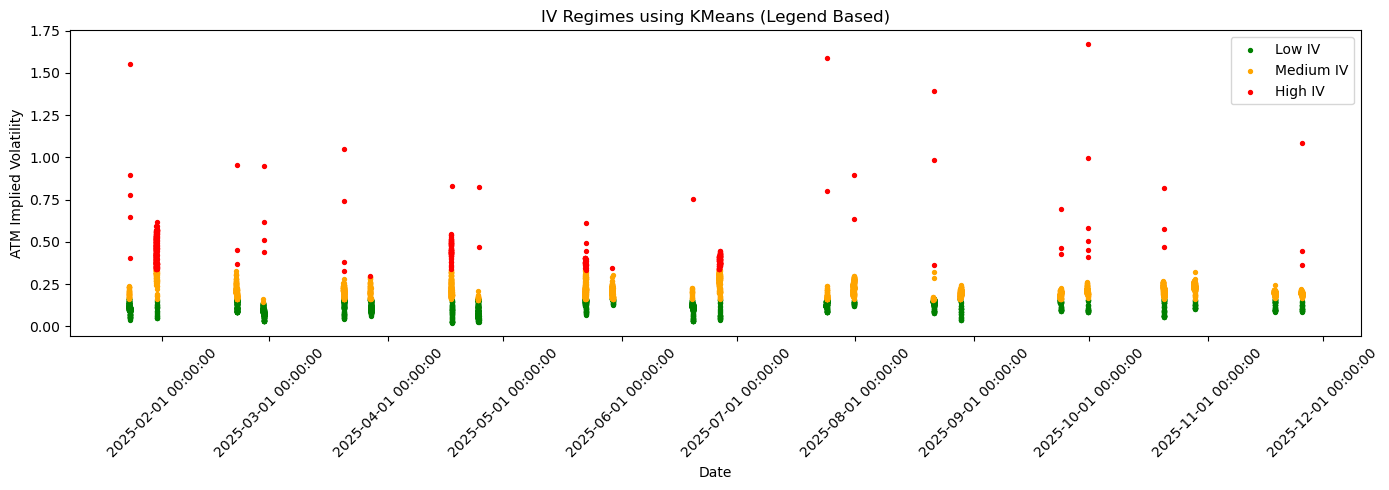

In [15]:
from sklearn.cluster import KMeans


X = df[["atm_iv", "iv_vol"]].dropna()


X_index = X.index

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

df.loc[X_index, "regime_kmeans"] = labels

cluster_order = (
    df.groupby("regime_kmeans")["atm_iv"]
    .mean()
    .sort_values()
    .index
    .tolist()
)

cluster_map = {cluster_order[0]: "Low IV",
               cluster_order[1]: "Medium IV",
               cluster_order[2]: "High IV"}

df.loc[X_index, "regime_kmeans_label"] = df.loc[X_index, "regime_kmeans"].map(cluster_map)

print(df.head())

# Plot  a graph

plt.figure(figsize=(14,5))

for label, color in zip(
    ["Low IV", "Medium IV", "High IV"],
    ["green", "orange", "red"]
):
    subset = df[df["regime_kmeans_label"] == label]
    plt.scatter(
        subset.index,
        subset["atm_iv"],
        label=label,
        s=8,
        color=color
    )

plt.title("IV Regimes using KMeans (Legend Based)")
plt.xlabel("Date")
plt.ylabel("ATM Implied Volatility")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.xticks(rotation=45) 
plt.tight_layout()
plt.legend()
plt.tight_layout()
plt.show()



## METHOD 3: Hidden Markov Model

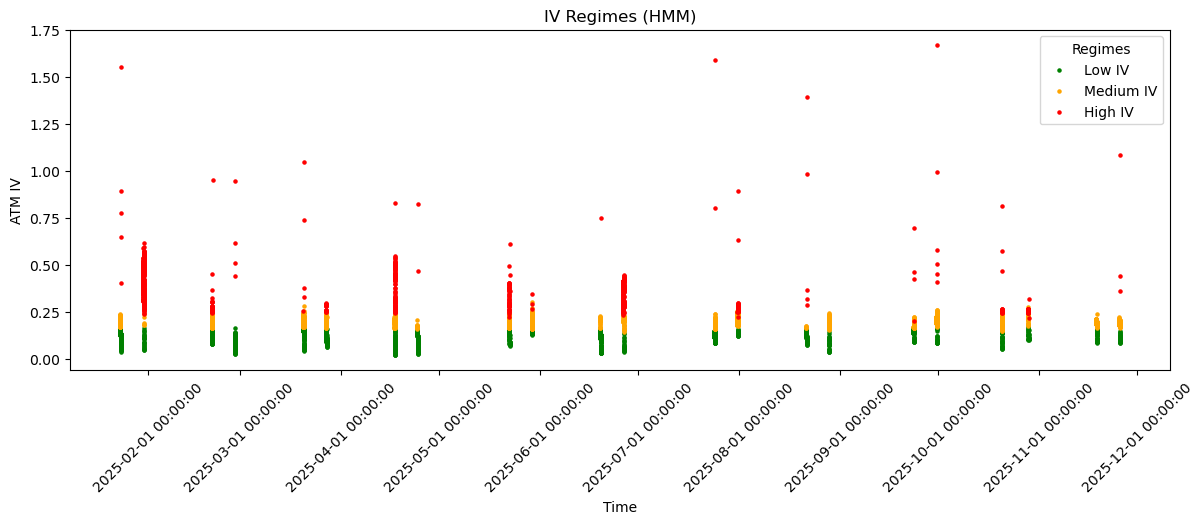

In [16]:
from hmmlearn.hmm import GaussianHMM
import numpy as np


X = df[["atm_iv"]].dropna().values
hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
hmm.fit(X)
states = hmm.predict(X)
df.loc[df["atm_iv"].dropna().index, "regime_hmm"] = states

# Get mean IV of each state
state_means = [X[states == i].mean() for i in range(3)]

# Sort states by mean IV =>lowest mean → state 0 (Low), highest → state 2 (High)
state_order = np.argsort(state_means)   


state_labels = {state_order[0]: "Low IV", 
                state_order[1]: "Medium IV", 
                state_order[2]: "High IV"}


df["regime_hmm_label"] = df["regime_hmm"].map(state_labels)



# Plot a graph

plt.figure(figsize=(12,5))

# Color map for labels
colors = {"Low IV": "green", "Medium IV": "orange", "High IV": "red"}

for label, color in colors.items():
    subset = df[df["regime_hmm_label"] == label]
    plt.scatter(subset.index, subset["atm_iv"], label=label, color=color, s=5)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.xticks(rotation=45) 
plt.tight_layout()
plt.title("IV Regimes (HMM)")
plt.xlabel("Time")
plt.ylabel("ATM IV")
plt.legend(title="Regimes")
plt.show()

